In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torchvision.models import vgg19
import torch
from torch import optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
!pip install torch-summary
from torchsummary import summary
from torchvision.transforms import ToPILImage

In [4]:
low_res_size = 32
high_res_size = 128

transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((low_res_size, low_res_size)),
    transforms.ToTensor(),
])

transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((high_res_size, high_res_size)),
    transforms.ToTensor(),
])


In [5]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform_low, transform_high):
        super(ImageDataset, self).__init__()
        self.transform_low = transform_low
        self.transform_high = transform_high
        self.root_dir = root_dir
        files_low = os.listdir(os.path.join(root_dir, "LR"))
        files_high = os.listdir(os.path.join(root_dir, "HR"))
        self.data = list(zip(files_low, files_high))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_low_file, img_high_file = self.data[index]

        low_res_pth = os.path.join(self.root_dir, "LR", img_low_file)
        high_res_pth = os.path.join(self.root_dir, "HR", img_high_file)

        try:
            low_res = np.array(Image.open(low_res_pth))
            high_res = np.array(Image.open(high_res_pth))

            low_res = low_res[:, :, :3]
            high_res = high_res[:, :, :3]

            low_res = self.transform_low(low_res)
            high_res = self.transform_high(high_res)
        except Exception as e:
            print(f"Error loading image {img_low_file} or {img_high_file}: {e}")

        return low_res, high_res


In [6]:
dataset = ImageDataset(root_dir='/content/drive/MyDrive/DATA_255/LAB2/srganimages', transform_low=transform_low, transform_high=transform_high)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


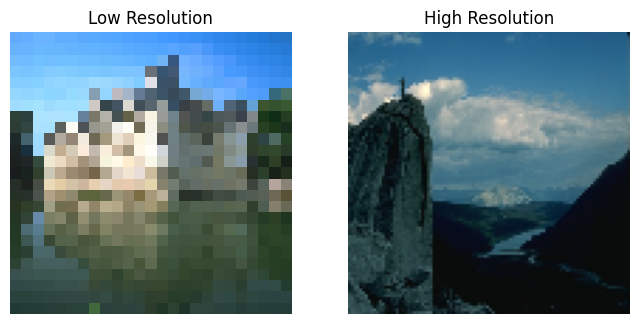

In [7]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms

transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((25, 25)),
    transforms.ToTensor(),
])

transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])

def show_image():
    dataset = ImageDataset(root_dir="/content/drive/MyDrive/DATA_255/LAB2/srganimages", transform_low=transform_low, transform_high=transform_high)
    train_loader = DataLoader(dataset, batch_size=1, num_workers=4)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for idx, (low_res, high_res) in enumerate(train_loader):
        low_res_img = low_res[0].permute(1, 2, 0).numpy()
        high_res_img = high_res[0].permute(1, 2, 0).numpy()

        axs[0].imshow(low_res_img)
        axs[0].set_title("Low Resolution")
        axs[0].axis('off')

        axs[1].imshow(high_res_img)
        axs[1].set_title("High Resolution")
        axs[1].axis('off')

        if idx == 0:
            break

    plt.show()
show_image()


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
epochs = 10
batch_size = 1
num_workers = 2
img_channels = 3

In [9]:
import torch
from torchvision.models import vgg19

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the pre-trained VGG19 model
vgg_model = vgg19(pretrained=True).eval().to(device)

lf = list(vgg_model.features)
for idx, layer in enumerate(lf):
    print(f"Layer {idx}: {layer}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:10<00:00, 52.9MB/s]


Layer 0: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 1: ReLU(inplace=True)
Layer 2: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 3: ReLU(inplace=True)
Layer 4: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 5: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 6: ReLU(inplace=True)
Layer 7: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 8: ReLU(inplace=True)
Layer 9: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 10: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 11: ReLU(inplace=True)
Layer 12: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 13: ReLU(inplace=True)
Layer 14: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 15: ReLU(inplace=True)
Layer 16: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 17: ReLU(inpl

In [10]:
import torch
import torch.nn as nn
from torchvision.models import vgg19

class vggL(nn.Module):
    def __init__(self):
        super(vggL, self).__init__()
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.vgg = vgg19(pretrained=True).features[:25].eval().to(device)
        self.loss = nn.MSELoss()

    def forward(self, first, second):
        vgg_first = self.vgg(first)
        vgg_second = self.vgg(second)
        perceptual_loss = self.loss(vgg_first, vgg_second)
        return perceptual_loss


In [11]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_activation=True, use_BatchNorm=True, **kwargs):
        super(ConvBlock, self).__init__()
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels) if use_BatchNorm else nn.Identity()
        self.use_activation = use_activation
        if use_activation:
            self.ac = nn.PReLU(num_parameters=out_channels)

    def forward(self, x):
        x = self.cnn(x)
        x = self.bn(x)
        if self.use_activation:
            x = self.ac(x)
        return x


In [12]:
import torch.nn as nn

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor ** 2, kernel_size=3, stride=1, padding=1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.ac = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        return self.ac(self.ps(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.b1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.b2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_activation=False
        )

    def forward(self, x):
        out = self.b1(x)
        out = self.b2(out)
        return out + x


In [13]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=16):
        super(Generator, self).__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=7, stride=1, padding=3, use_BatchNorm=False)
        self.res = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_blocks)])
        self.conv = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_activation=False)
        self.up1 = UpsampleBlock(num_channels, scale_factor=2)
        self.up2 = UpsampleBlock(num_channels, scale_factor=2)
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        x = self.initial(x)
        c = self.res(x)
        c = self.conv(c) + x
        c = self.up1(c)
        c = self.up2(c)
        return torch.tanh(self.final(c))


In [14]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super(Discriminator, self).__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    use_activation=True,
                    use_BatchNorm=idx != 0,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)

        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.mlp(x)
        return x


In [15]:
from torchsummary import summary
generator = Generator(in_channels=3, num_channels=64, num_blocks=16)
discriminator = Discriminator(in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512])
generator_input_size = (3, 32, 32)
discriminator_input_size = (3, 128, 128)
print("Generator Summary:")
summary(generator, generator_input_size)

print("\nDiscriminator Summary:")
summary(discriminator, discriminator_input_size)


Generator Summary:
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          9,472
|    └─Identity: 2-2                     [-1, 64, 32, 32]          --
|    └─PReLU: 2-3                        [-1, 64, 32, 32]          64
├─Sequential: 1-2                        [-1, 64, 32, 32]          --
|    └─ResidualBlock: 2-4                [-1, 64, 32, 32]          --
|    |    └─ConvBlock: 3-1               [-1, 64, 32, 32]          37,120
|    |    └─ConvBlock: 3-2               [-1, 64, 32, 32]          37,056
|    └─ResidualBlock: 2-5                [-1, 64, 32, 32]          --
|    |    └─ConvBlock: 3-3               [-1, 64, 32, 32]          37,120
|    |    └─ConvBlock: 3-4               [-1, 64, 32, 32]          37,056
|    └─ResidualBlock: 2-6                [-1, 64, 32, 32]          --
|    |    └─ConvBlock: 3-5               [-1, 6

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 8, 8]           --
|    └─ConvBlock: 2-1                    [-1, 64, 128, 128]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 128, 128]        1,792
|    |    └─Identity: 3-2                [-1, 64, 128, 128]        --
|    |    └─PReLU: 3-3                   [-1, 64, 128, 128]        64
|    └─ConvBlock: 2-2                    [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 64, 64]          36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 64, 64]          128
|    |    └─PReLU: 3-6                   [-1, 64, 64, 64]          64
|    └─ConvBlock: 2-3                    [-1, 128, 64, 64]         --
|    |    └─Conv2d: 3-7                  [-1, 128, 64, 64]         73,856
|    |    └─BatchNorm2d: 3-8             [-1, 128, 64, 64]         256
|    |    └─PReLU: 3-9                   [-1, 128, 64, 64]         128
|

In [16]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train_progress(epoch, num_epochs, d_losses, g_losses):
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.title("Training progress")
    plt.plot(d_losses,label="Discriminator loss")
    plt.plot(g_losses,label="Generator loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    print(f"Epoch [{epoch}/{num_epochs}], Discriminator loss: {d_losses[-1]:.4f}, Generator loss: {g_losses[-1]:.4f}")

In [17]:
gen = Generator(in_channels=3).to(device)
disc = Discriminator(in_channels=3).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = vggL()

In [18]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.files = [os.path.join(root_dir, file) for file in os.listdir(root_dir)]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img = Image.open(self.files[index])
        if self.transform:
            img = self.transform(img)
        return img
test_dataset = TestDataset(root_dir="/content/drive/MyDrive/DATA_255/LAB2/srgantestimages", transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=num_workers)


In [19]:
from tqdm import tqdm
num_epoches=10
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss, device):
    loop = tqdm(loader, leave=True)
    disc_loss = 0
    gen_loss = 0
    for idx, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(device)
        low_res = low_res.to(device)

        # Train Discriminator
        fake = gen(low_res)
        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())
        disc_loss_real = bce(disc_real, torch.ones_like(disc_real))
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        disc_loss = disc_loss_fake + disc_loss_real
        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()

        # Train Generator
        disc_fake = disc(fake)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
        gen_loss = loss_for_vgg + adversarial_loss
        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()
        loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
        loop.set_postfix(gen_loss=gen_loss.item(), disc_loss=disc_loss.item())

    return gen_loss.detach().cpu().item(), disc_loss.detach().cpu().item()


In [20]:
d_losses = []
g_losses = []
i = 0
epochs = 10

In [21]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import DataLoader
def plot_train(gen, device):
    transform_low = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((32,32)),
        transforms.ToTensor(),
    ])

    transform_high = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
    dataset_test = ImageDataset(root_dir="/content/drive/MyDrive/DATA_255/LAB2/srganimages",
                                transform_low=transform_low, transform_high=transform_high)
    loader = DataLoader(dataset_test, batch_size=16, num_workers=2)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    chosen_batch = random.randint(0, len(loader)-1)
    for idx, (low_res, high_res) in enumerate(loader):
        if chosen_batch == idx:
            chosen = random.randint(0, len(low_res)-1)
            axs[0].imshow(low_res[chosen].permute(1, 2, 0))
            axs[0].set_title("Low Res")
            axs[0].axis('off')
            with torch.no_grad():
                upscaled_img = gen(low_res[chosen].to(device).unsqueeze(0))
            axs[1].imshow(upscaled_img.squeeze(0).cpu().permute(1, 2, 0))
            axs[1].set_title("Predicted")
            axs[1].axis('off')
            axs[2].imshow(high_res[chosen].permute(1, 2, 0))
            axs[2].set_title("High Res")
            axs[2].axis('off')

            break

    plt.show()
    gen.train()


In [22]:

transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
train_dataset = ImageDataset(root_dir="/content/drive/MyDrive/DATA_255/LAB2/srganimages",
                             transform_low=transform_low,
                             transform_high=transform_high)
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=2, shuffle=True)


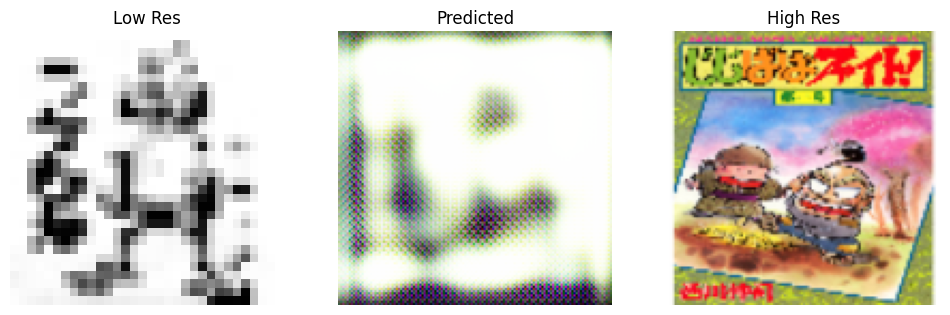

Epoch 1/10


Epoch [0/10]: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s, disc_loss=0.832, gen_loss=0.0239]

Gen loss: 0.023859631270170212 , Disc loss: 0.8318794369697571


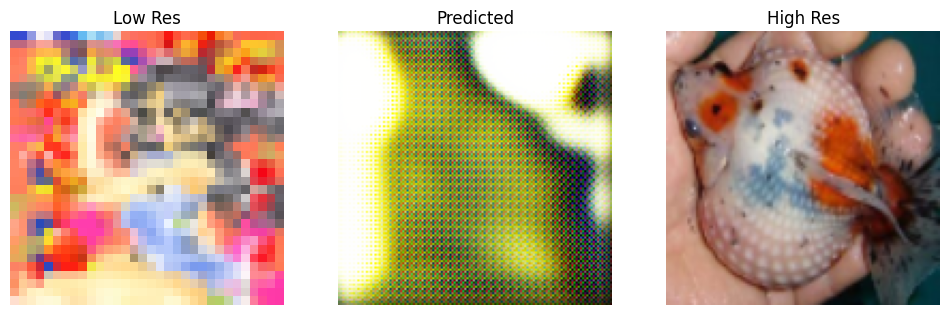

Epoch 2/10


Epoch [1/10]: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s, disc_loss=2.22, gen_loss=0.0257]


Gen loss: 0.025691485032439232 , Disc loss: 2.220609664916992


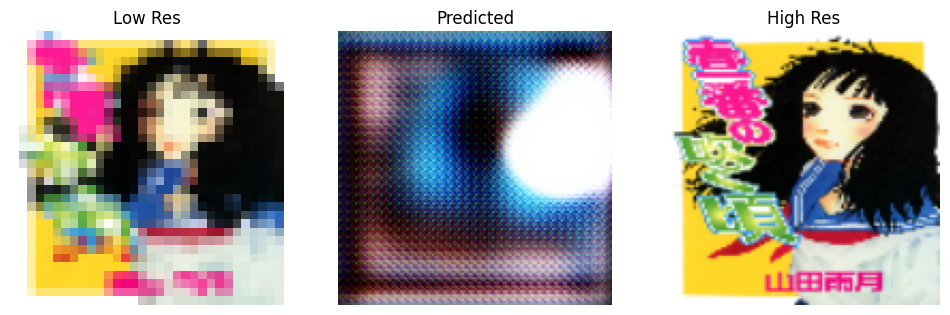

Epoch 3/10


Epoch [2/10]: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s, disc_loss=0.114, gen_loss=0.0253]


Gen loss: 0.02527715265750885 , Disc loss: 0.11444637179374695


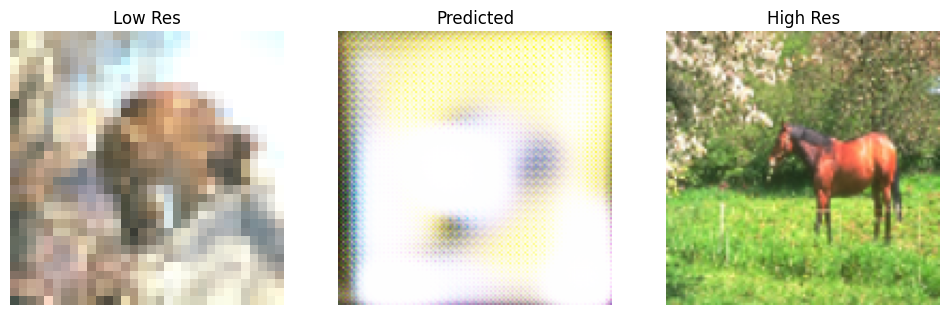

Epoch 4/10


Epoch [3/10]: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s, disc_loss=0.698, gen_loss=0.0208]


Gen loss: 0.020758377388119698 , Disc loss: 0.6979306936264038


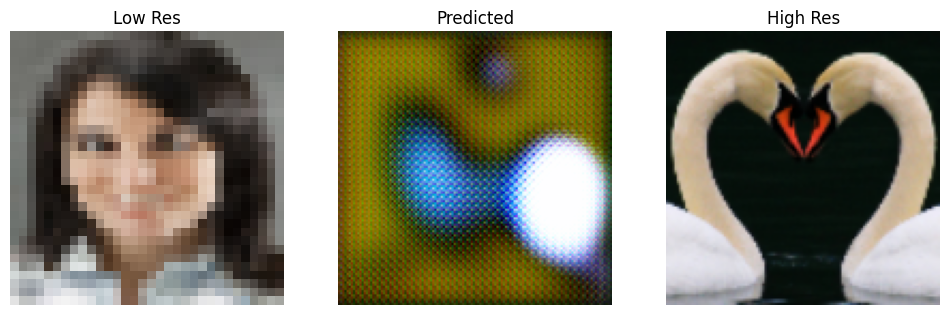

Epoch 5/10


Epoch [4/10]: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s, disc_loss=0.667, gen_loss=0.0252]


Gen loss: 0.025191202759742737 , Disc loss: 0.6670759916305542


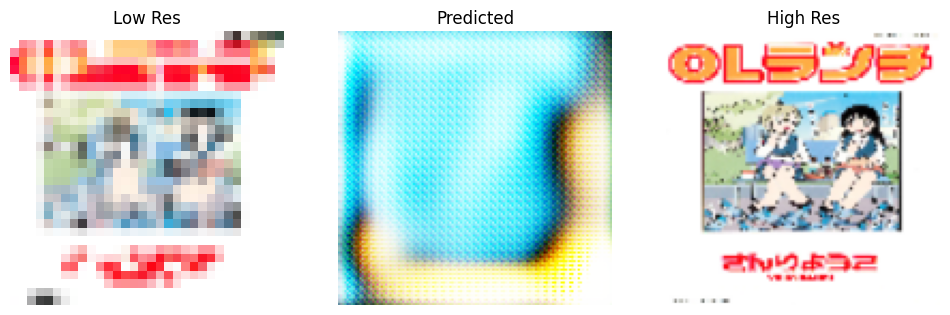

Epoch 6/10


Epoch [5/10]: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s, disc_loss=0.103, gen_loss=0.0195]


Gen loss: 0.01946709305047989 , Disc loss: 0.10340721905231476


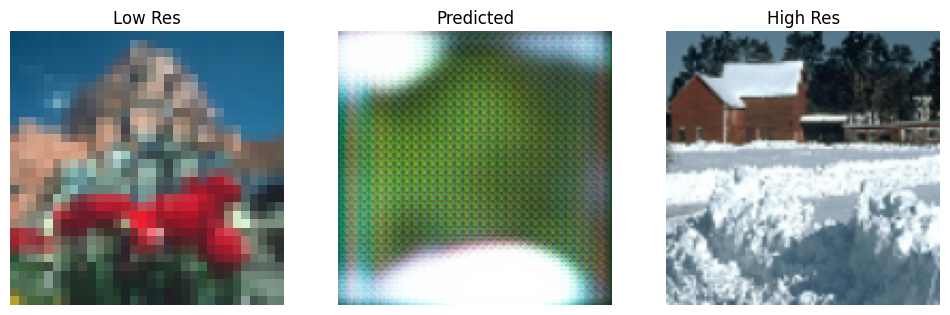

Epoch 7/10


Epoch [6/10]: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s, disc_loss=1.82, gen_loss=0.0206]


Gen loss: 0.020608259364962578 , Disc loss: 1.8217555284500122


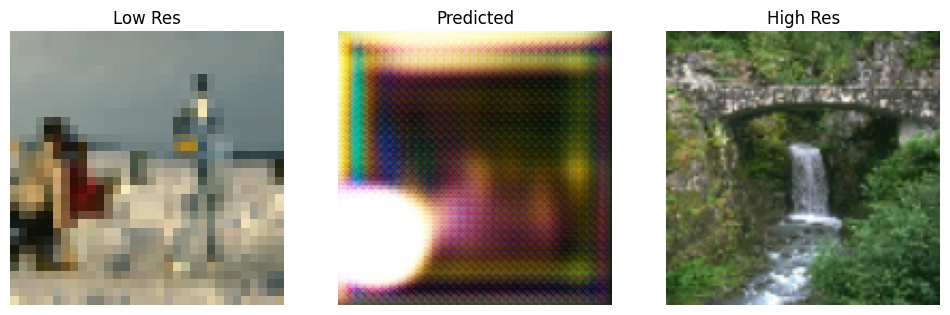

Epoch 8/10


Epoch [7/10]: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s, disc_loss=0.809, gen_loss=0.0197]


Gen loss: 0.019663605839014053 , Disc loss: 0.8094923496246338


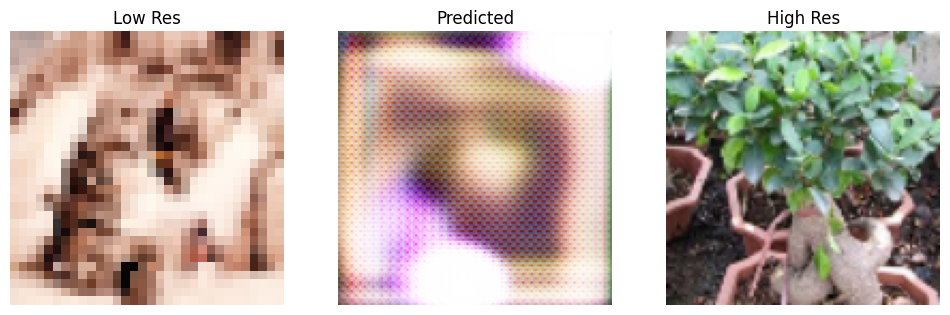

Epoch 9/10


Epoch [8/10]: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s, disc_loss=1.57, gen_loss=0.0237]


Gen loss: 0.023708432912826538 , Disc loss: 1.5696221590042114


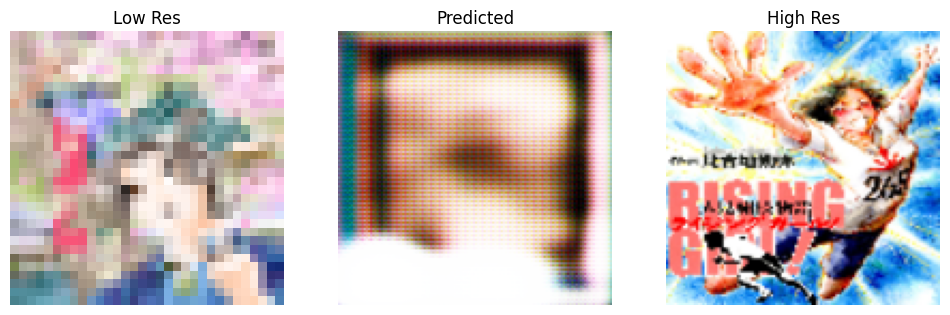

Epoch 10/10


Epoch [9/10]: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s, disc_loss=0.784, gen_loss=0.0216]


Gen loss: 0.021648477762937546 , Disc loss: 0.7842752933502197


In [24]:
import os
import torch
num_epochs=10
d_losses = []
g_losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for epoch in range(epochs):
    plot_train(gen, device)
    print(f"Epoch {epoch + 1}/{epochs}")
    gen_loss, disc_loss = train_fn(train_loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss, device)
    print('Gen loss:', gen_loss, ', Disc loss:', disc_loss)

    d_losses.append(disc_loss)
    g_losses.append(gen_loss)
    if (epoch + 1) % 2 == 0:
        savedir = f'/content/drive/MyDrive/DATA_255/LAB2/output_changeincode/{epoch + 1}/'
        os.makedirs(savedir, exist_ok=True)
        torch.save(gen.state_dict(), os.path.join(savedir, "checkpoint_gen.pth"))
        torch.save(disc.state_dict(), os.path.join(savedir, "checkpoint_disc.pth"))


In [27]:
import os
import torch
num_epochs=10
d_losses = []
g_losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for epoch in range(epochs):
    #plot_train(gen, device)
    print(f"Epoch {epoch + 1}/{epochs}")
    gen_loss, disc_loss = train_fn(train_loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss, device)
    print('Gen loss:', gen_loss, ', Disc loss:', disc_loss)

    d_losses.append(disc_loss)
    g_losses.append(gen_loss)
    if (epoch + 1) % 2 == 0:
        savedir = f'/content/drive/MyDrive/DATA_255/LAB2/output_changeincode/{epoch + 1}/'
        os.makedirs(savedir, exist_ok=True)
        torch.save(gen.state_dict(), os.path.join(savedir, "checkpoint_gen.pth"))
        torch.save(disc.state_dict(), os.path.join(savedir, "checkpoint_disc.pth"))


Epoch 1/10


Epoch [0/10]: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s, disc_loss=0.419, gen_loss=0.0252]


Gen loss: 0.02519899420440197 , Disc loss: 0.41888701915740967
Epoch 2/10


Epoch [1/10]: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s, disc_loss=0.956, gen_loss=0.0256]


Gen loss: 0.0256013423204422 , Disc loss: 0.9558266997337341
Epoch 3/10


Epoch [2/10]: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s, disc_loss=0.0772, gen_loss=0.0238]


Gen loss: 0.023772122338414192 , Disc loss: 0.07717221975326538
Epoch 4/10


Epoch [3/10]: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s, disc_loss=3.67, gen_loss=0.0237]


Gen loss: 0.02373460680246353 , Disc loss: 3.672661066055298
Epoch 5/10


Epoch [4/10]: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s, disc_loss=1.5, gen_loss=0.0244]


Gen loss: 0.024392737075686455 , Disc loss: 1.4956409931182861
Epoch 6/10


Epoch [5/10]: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s, disc_loss=0.228, gen_loss=0.0272]


Gen loss: 0.027207093313336372 , Disc loss: 0.2281121015548706
Epoch 7/10


Epoch [6/10]: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s, disc_loss=1.09, gen_loss=0.0252]


Gen loss: 0.025159712880849838 , Disc loss: 1.0854294300079346
Epoch 8/10


Epoch [7/10]: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s, disc_loss=0.227, gen_loss=0.0209]


Gen loss: 0.020884748548269272 , Disc loss: 0.2270229458808899
Epoch 9/10


Epoch [8/10]: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s, disc_loss=0.134, gen_loss=0.0266]


Gen loss: 0.02664959989488125 , Disc loss: 0.13404704630374908
Epoch 10/10


Epoch [9/10]: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s, disc_loss=0.0057, gen_loss=0.0255]


Gen loss: 0.02553538605570793 , Disc loss: 0.005700387060642242


Now testing it on Test images

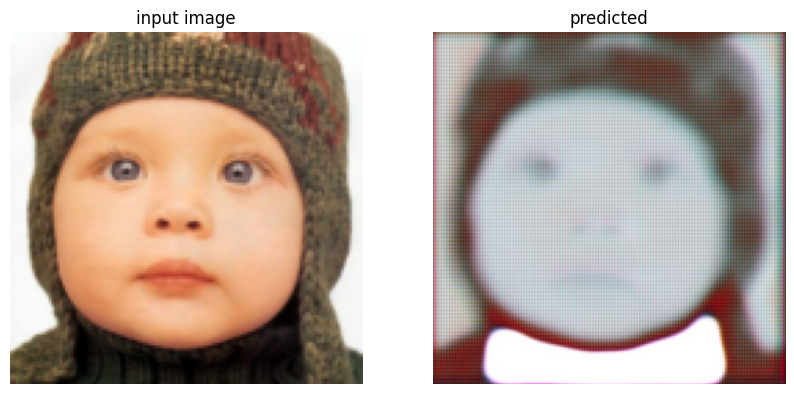

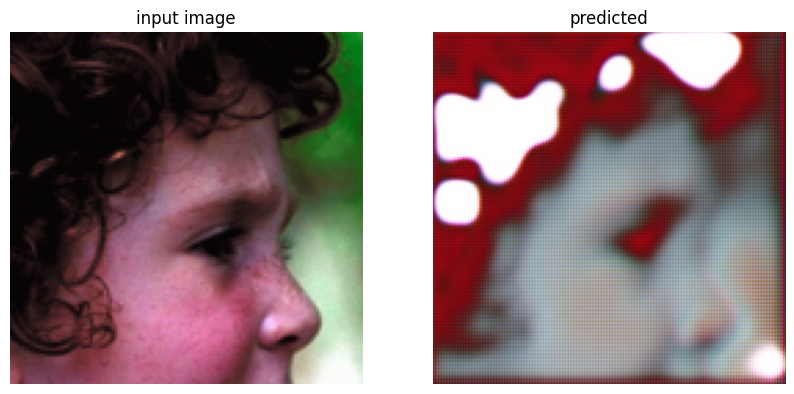

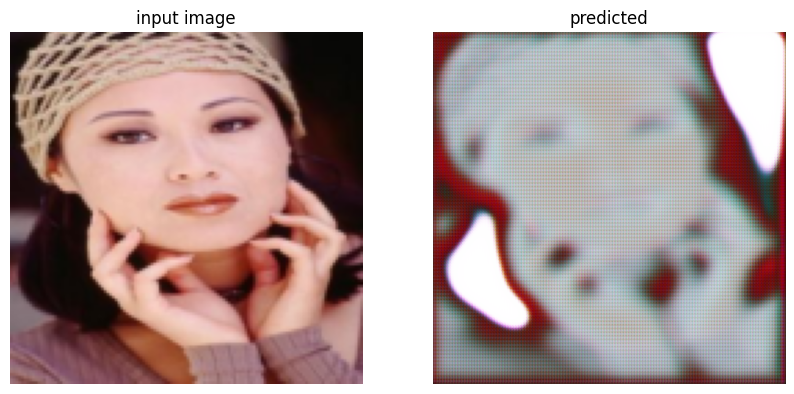

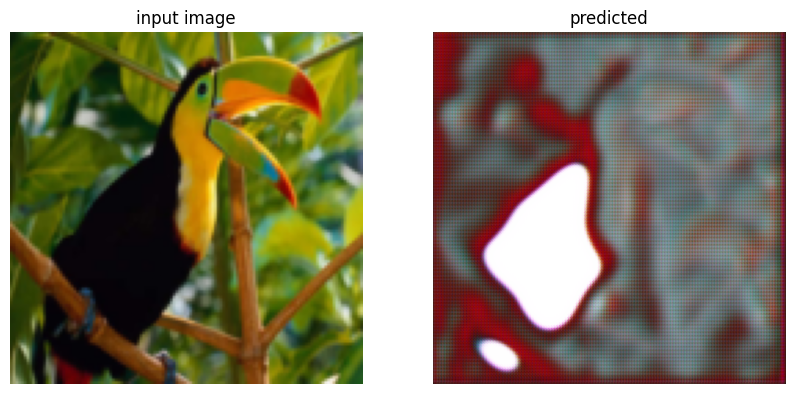

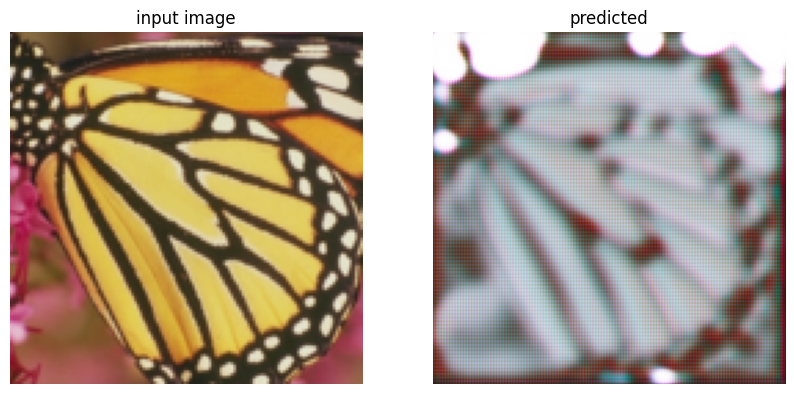

In [25]:
def plot_generated(gen, device, root_dir="/content/drive/MyDrive/DATA_255/LAB2/srgantestimages/Test"):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
    dataset = TestDataset(root_dir=root_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=1, num_workers=2)
    for idx, img in enumerate(loader):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjusted figure size for two subplots
        axs[0].imshow(img.squeeze(0).permute(1, 2, 0).numpy())
        axs[0].set_title("input image")
        axs[0].axis('off')
        with torch.no_grad():
            upscaled_img = gen(img.to(device))
        axs[1].imshow(upscaled_img.squeeze(0).cpu().permute(1, 2, 0).numpy())
        axs[1].set_title("predicted")
        axs[1].axis('off')
        plt.show()
plot_generated(gen, device, root_dir="/content/drive/MyDrive/DATA_255/LAB2/srgantestimages/Test")


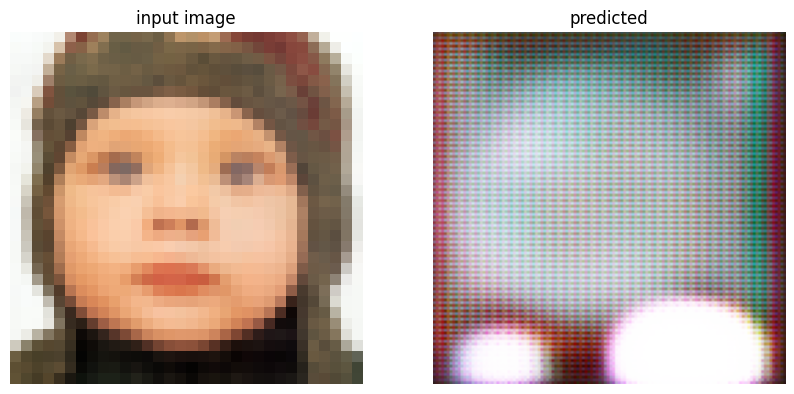

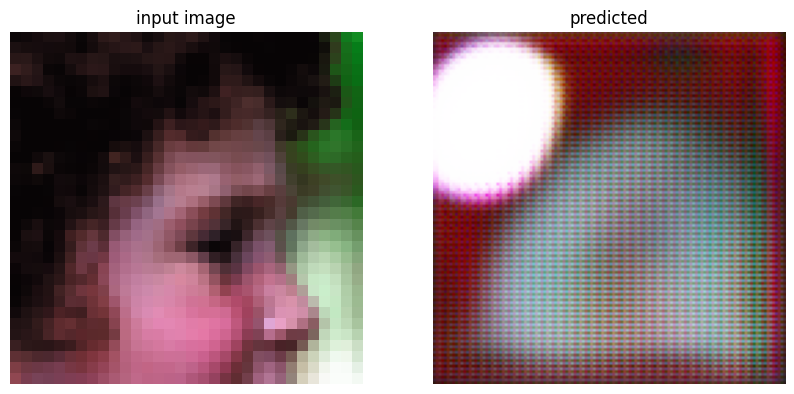

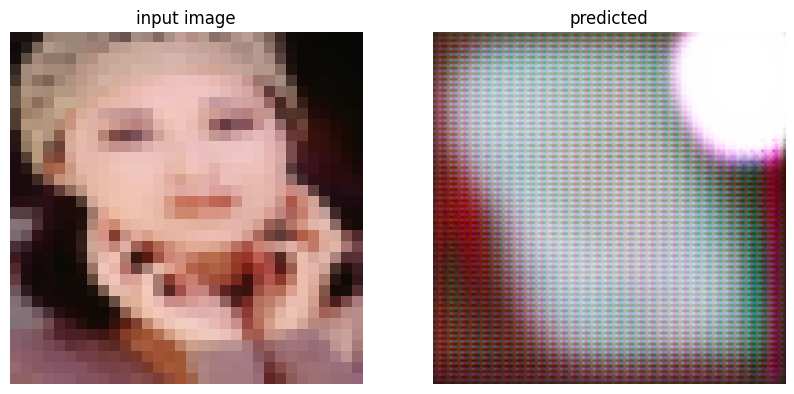

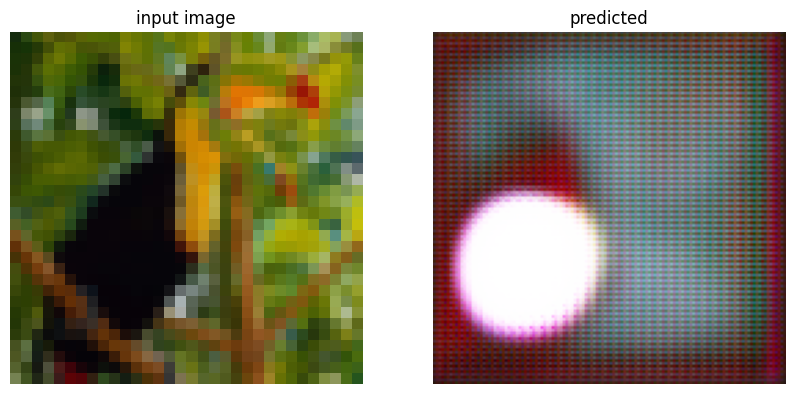

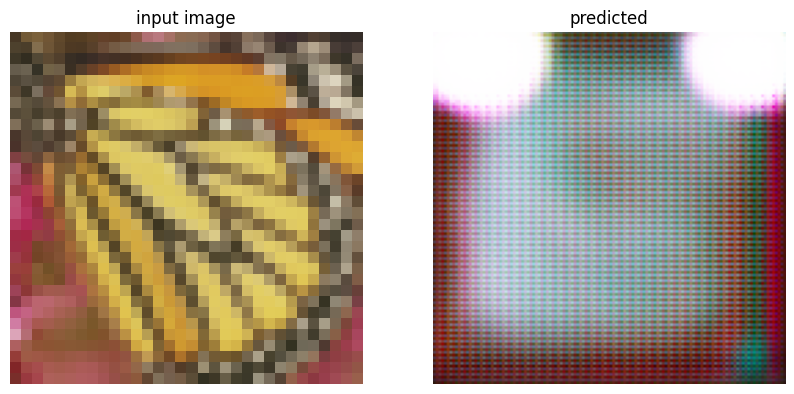

In [26]:
def plot_generated(gen, device, root_dir="/content/drive/MyDrive/DATA_255/LAB2/srgantestimages/Test"):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ])
    dataset = TestDataset(root_dir=root_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=1, num_workers=2)

    for idx, img in enumerate(loader):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].imshow(img.squeeze(0).permute(1, 2, 0).numpy())
        axs[0].set_title("input image")
        axs[0].axis('off')
        with torch.no_grad():
            upscaled_img = gen(img.to(device))
        axs[1].imshow(upscaled_img.squeeze(0).cpu().permute(1, 2, 0).numpy())
        axs[1].set_title("predicted")
        axs[1].axis('off')
        plt.show()
plot_generated(gen, device, root_dir="/content/drive/MyDrive/DATA_255/LAB2/srgantestimages/Test")
